# Lab 5: Robust Mixture Models

The goal of this lab session is to study robust mixture models. You will code the EM algorithm to estimate the parameters of a mixture of multivariate t-distributions. 

You have to send the filled notebook named **"L5_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before October 31 at 23:59. Please put **"AML-L5"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import special
import scipy
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.datasets import make_sparse_spd_matrix
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

### $t$MM

Reference: https://people.smp.uq.edu.au/GeoffMcLachlan/pm_sc00.pdf 

1 - Prove that in the $t$MM model

$$U_i|(X_i=x_i,Z_{ij}=1) \sim \Gamma\left(\frac{\nu_j+p}{2}, \frac{\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2}\right)$$

$\begin{align*} 
\textit{Since } f_{U_i|X_i=x_i,Z_{i,j}=1}(u_i) &= \frac{f_{U_i|Z_{i,j}=1}(u_i)f_{X_i|U_i=u_i,Z_{i,j}=1}(x_i)}{f_{X_i|Z_{i,j}=1}(x_i)} \\
\textit{We have } f_{U_i|Z_{i,j}=1}(u_i) &\ \ \alpha \ \ f_{U_i|Z_{i,j}=1}(u_i) \frac{e^{-\frac{1}{2} \delta(x,\mu,\frac{\Sigma}{u_i})}}{\sqrt{|\frac{\Sigma}{u_i}|}}  \ \ \ \textit{  ($\alpha$ = proportionnal to) }  \\
f_{U_i|Z_{i,j}=1}(u_i) &\ \ \alpha \ \ f_{U_i|Z_{i,j}=1}(u_i)   \frac{e^{-\frac{1}{2} \delta(x,\mu,\frac{\Sigma}{u_i})}} {\frac{\sqrt{|\Sigma|}}{{|u_i|}^{\frac{p}{2}}}} \\
f_{U_i|Z_{i,j}=1}(u_i) &\ \ \alpha \ \ u_{i}^{\frac{\nu}{2}}  {|u_i|}^{\frac{p}{2}} e^{-\frac{\nu}{2} -\frac{1}{2} \delta(x,\mu,\frac{\Sigma}{u_i})}\mathbb{1}_{\mathbb{R}^{+}}(u_i) \\
\textit{Finally, } f_{U_i|Z_{i,j}=1}(u_i) &\ \ \alpha \ \ u_{i}^{\frac{\nu}{2}+\frac{p}{2}} e^{-\frac{\nu}{2} -\frac{1}{2} \delta(x,\mu,\frac{\Sigma}{u_i})}\mathbb{1}_{\mathbb{R}^{+}}(u_i) \\
\textit{Therefore, we have }
U_i|(X_i=x_i,Z_{ij}=1) & \sim \Gamma\left(\frac{\nu_j+p}{2}, \frac{\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2}\right)
 \end{align*} $


2 - Fill in the following class to implement EM for a multivariate $t$MM. You can use the gamma and digamma functions and also a solver to find roots. 

In [2]:
class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, tol = 10**-6, it_max = 100):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n, p = X.shape
        k = self.k
        self.mu_ = KMeans(n_clusters=k, max_iter=50).fit(X).cluster_centers_
        self.Sigma_ = np.zeros((k, p, p))
        for i in range(k) :
            self.Sigma_[i, :] = make_sparse_spd_matrix(p)
        self.alpha_ = np.random.rand(k)
        self.alpha_ = self.alpha_/np.sum(self.alpha_)
        
        self.cond_prob_ = np.zeros((n, k))
        
        it = 0
        convergence = False
        
        while not convergence :
            density = np.zeros((n, k))
            for i in range (k):
                density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
            
            cond_prob_ = self.alpha_.T * density
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_ 
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
                                 
            mu_ = (1/self.alpha_)[:, np.newaxis] * np.mean(np.expand_dims(X, axis = 1) * self.cond_prob_[:, :, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            
            tmp = np.expand_dims(X, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = (1/self.alpha_)[:, np.newaxis, np.newaxis] * np.mean(self.cond_prob_[:, :, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                              axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            it = it + 1
            err = delta_alpha + delta_cond_prob + delta_mu_ + delta_sigma
            if it > it_max or (err < tol) :
                convergence  = True
        print("Fin du fitting à l'iteration :", it , '. Error : ', err)
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)   
        
        return self
        

In [3]:
class my_tMM():
    
    def __init__(self, k):
        '''
        Parameters:
        K: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        u_: (n, K) np.array
            expectation of the U variable 
        dof_: (K, ) np.array
            degrees of freedom of each component
        labels_: (n, ) np.array
            labels for data points
        '''
        
        self.K = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.dof_ = None
        self.u_ = None
        
    def fit(self, X, it_max, tol, init):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        def sqr_mahalanobis(x, mu, Sigma):
            # compute the squared Mahalanobis distance
            
            return (x - mu).T @ np.linalg.inv(Sigma) @ (x-mu)
        
        def pdf_multivariate_t(X, mu, Sigma, dof):
            p = X.shape[1]
            delta = np.apply_along_axis(sqr_mahalanobis, arr = X, axis = 1, mu = mu, Sigma = Sigma)
            
            result = special.gamma((dof + p)/2) * np.sqrt(1/scipy.linalg.det(Sigma))
            result /= (np.pi * dof)**(p/2) * special.gamma(dof/2)  * (1 + delta)**((dof + p)/2)
            
            return result
        
        def function_dof(dof, old_dof, cond_prob, u, k, p):
            x = -special.digamma(dof/2) + np.log(dof/2) + special.digamma((old_dof+p)/2) - np.log((old_dof+p)/2)
            x += np.sum(cond_prob * (np.log(u) - u), axis = 0)/np.sum(cond_prob, axis = 0)
            return x
            
        # initialization
        k = self.K
        n, p = X.shape
        self.Sigma_ = np.zeros((k, p, p))
        self.dof_ = np.random.rand(k)
        u_ = np.zeros((n, k))
        for i in range(k) :
            self.Sigma_[i, :] = make_sparse_spd_matrix(p)
        self.alpha_ = np.random.rand(k)
        self.alpha_ = self.alpha_/np.sum(self.alpha_)
        self.cond_prob_ = np.zeros((n, k))
        self.u_ = np.zeros((n, k))
        
        
        # fit a k-mean clustering to find approximately the means
        if init == 'kmeans':
            self.mu_ = KMeans(n_clusters=k, max_iter=50).fit(X).cluster_centers_
        if init == 'random' :
            self.mu_ = 1- 2 * np.random.rand(k, p)

        convergence = False
        it = 0
        while not convergence :
            
            # Expectation-step
            density = np.zeros((n, k))
            for i in range (k):
                density[:, i] = pdf_multivariate_t(X, self.mu_[i], self.Sigma_[i], self.dof_[i])
            
            cond_prob_ = self.alpha_.T * density
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
            
            for i in range(k) :
                delta = np.apply_along_axis(sqr_mahalanobis, arr = X, axis = 1, mu = self.mu_[i], Sigma = self.Sigma_[i])
                u_[:, i] = (self.dof_[i] + p)/(self.dof_[i] + delta)
            delta_u = np.max(np.abs(self.u_ - u_))    
            self.u_ = u_

            # Maximization-step
            mu_ = np.sum(self.u_[:, :, np.newaxis] * self.cond_prob_[:, :, np.newaxis] * X[:, np.newaxis, :], axis = 0)
            mu_ /= np.sum(self.u_[:, :, np.newaxis] * self.cond_prob_[:, :, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            
            tmp = np.expand_dims(X, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = np.sum(self.u_[:, :, np.newaxis, np.newaxis ] * self.cond_prob_[:, :, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                          axis = 0)
            Sigma_ /= np.sum(self.cond_prob_[:, :, np.newaxis, np.newaxis], axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            
            # update the degrees of freedom variable
            dof_ = self.dof_
            self.dof_ = scipy.optimize.root(function_dof, dof_, args =(self.dof_, self.cond_prob_, self.u_, k, p)).x
            delta_dof = np.max(np.abs(self.dof_ - dof_))
            it = it + 1
            err = delta_cond_prob + delta_mu_ + delta_sigma + delta_u
            if it > it_max or (err < tol) :
                convergence  = True        

        print("Fin du fitting à l'iteration :", it , '. Error : ', err)    
        
        # Update labels   
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)   
        return self
            

3 - Generate one dataset with mixtures of t-distributions that ilustrate when tMM and GMM behave similarly and another dataset where tMM has a better performance

In [4]:
def generate_t(shape, mean, sigma, dof):
    ## generate a t distribution with params shape, mean, sigma and dof
    n, p = shape
    u = np.random.chisquare(dof, n)/dof
    z = np.random.multivariate_normal(np.zeros(p),sigma,(n,))
    return mean + z/np.sqrt(u)[:, np.newaxis]
def generate_data(k, p, scale_dof, seed):
    list_of_x = []
    labels = []
    np.random.seed(seed)
    for i in range(k) :
        n_i = np.random.randint(500, 1000)
        mu_i = (1 - 2* np.random.rand(p))*(i+1)**(1.1) * (-1)**i
        vec_cov_i = np.random.rand(p, p)
        cov_i = np.dot(vec_cov_i, vec_cov_i.T)
        dof_i =  scale_dof*np.random.rand()
        #print(dof_i)
        x_i = generate_t((n_i, p), mu_i, cov_i, dof_i)
        list_of_x.append(x_i)
        labels.append(i * np.ones(n_i))
    X = np.concatenate(list_of_x)
    labels = np.concatenate(labels)
    shuffle = np.arange(len(X))
    np.random.shuffle(shuffle)
    X = X[shuffle]
    labels = labels[shuffle]   
    return X, labels
def plot_cluster(X, model_tmm, model_gmm, kmeans, labels):
    fig, ax = plt.subplots(2,2, figsize =(14, 8), sharex = True, sharey = True)
    ax = ax.flatten()
    ax[0].scatter(X[:, 0].T, X[:, 1].T, c=labels, **plot_kwds)
    ax[0].set_title('real labels', size = 14)
    ax[1].scatter(X[:, 0].T, X[:, 1].T, c=model_tmm.labels_, **plot_kwds)
    ax[1].set_title('TMM predicted labels', size = 14);
    ax[2].scatter(X[:, 0].T, X[:, 1].T, c=kmeans.labels_, **plot_kwds)
    ax[2].set_title('k means predicted labels', size = 14)
    ax[3].scatter(X[:, 0].T, X[:, 1].T, c=model_gmm.labels_, **plot_kwds)
    ax[3].set_title('GMM predicted labels', size = 14);
k = 4
p = 2
X_1, labels_1 = generate_data(k = 4, p = 2, scale_dof=10, seed = 12)
X_2, labels_2 = generate_data(k = 4, p = 2, scale_dof= 60, seed = 12)

In [5]:
model_gmm = my_GMM(k = 4)
model_tmm = my_tMM(k = 4)

Fin du fitting à l'iteration : 159 . Error :  9.476282417264503e-06
Fin du fitting à l'iteration : 191 . Error :  9.846950995431696e-06


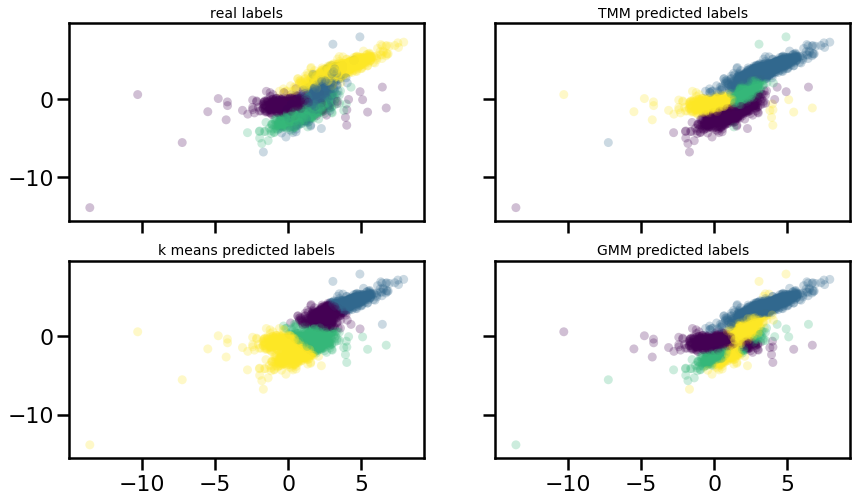

In [6]:
X = X_1
model_tmm.fit(X, it_max = 1000, tol = 10**-5, init = 'kmeans')
model_gmm.fit(X, it_max = 1000, tol = 10**-5);
kmeans = KMeans(n_clusters=k, max_iter=200).fit(X)
plot_cluster(X, model_tmm, model_gmm, kmeans, labels_1)

### Observations and comments 
We observe that : 
*  The TMM results are quite good. This is not suprising considering the fact that the entry distribution are following a student distribution. 
* The GMM results are also good if we take into account the proximity between the clusters. However, one cluster is missed and the model considers a different cluster.  This is due to the heavier tail of the student distribution that requires a different gaussian (with high standard deviation) for its modelling. 
* k means results are quite bad. 

Fin du fitting à l'iteration : 145 . Error :  9.417345515211339e-07
Fin du fitting à l'iteration : 64 . Error :  8.417578122449365e-07


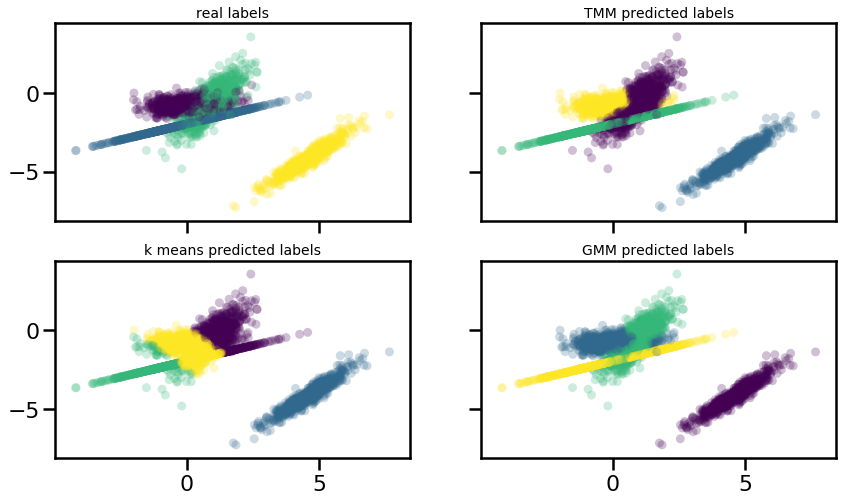

In [7]:
X = X_2
model_tmm.fit(X, it_max = 1000, tol = 10**-6, init = 'kmeans')
model_gmm.fit(X, it_max = 1000, tol = 10**-6);
kmeans = KMeans(n_clusters=k, max_iter=200).fit(X)
plot_cluster(X, model_tmm, model_gmm, kmeans, labels_2)

4 - Modify the my_GMM class to implement the Extra Uniform Cluster Algorithm

In [8]:
class my_GMM_rnd_noise():
    
    def __init__(self, k):
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, tol = 10**-6, it_max = 100, mode = 'default'):
        n, p = X.shape
        k = self.k
        self.mu_ = KMeans(n_clusters=k, max_iter=50).fit(X).cluster_centers_
        self.Sigma_ = np.zeros((k, p, p))
        for i in range(k) :
            self.Sigma_[i, :] = make_sparse_spd_matrix(p)
        self.alpha_ = np.random.rand(k+1)
        self.alpha_ = self.alpha_/np.sum(self.alpha_)
        
        self.cond_prob_ = np.zeros((n, k+1))
        inv_volume = 1/ np.prod(np.max(X, axis = 0) - np.min(X, axis = 0)) ## Computing the inverse 
                                                                           ## of the volume 
        it = 0
        convergence = False
        while not convergence :
            density = np.zeros((n, k+1))
            for i in range (k):
                density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
            density[:, k] = inv_volume ## Adding probability of being a noise
            
            cond_prob_ = self.alpha_.T * density
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_ 
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
            
            ## Updating mu_ and Sigma_   
            
            mu_ = (1/self.alpha_)[:k, np.newaxis] * np.mean(np.expand_dims(X, axis = 1) * self.cond_prob_[:, :k, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            
            tmp = np.expand_dims(X, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = (1/self.alpha_)[:k, np.newaxis, np.newaxis] * np.mean(self.cond_prob_[:, :k, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                              axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            it = it + 1
            
            err = delta_alpha + delta_cond_prob + delta_mu_ + delta_sigma
            if it > it_max or (err < tol) :
                convergence  = True
                
        print("Fin du fitting à l'iteration :", it , '. Error : ', err)   
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)   
        
        return self
        

Fin du fitting à l'iteration : 123 . Error :  8.864357857289729e-07
Fin du fitting à l'iteration : 187 . Error :  9.98508592122728e-07
Fin du fitting à l'iteration : 357 . Error :  9.63476517318318e-09


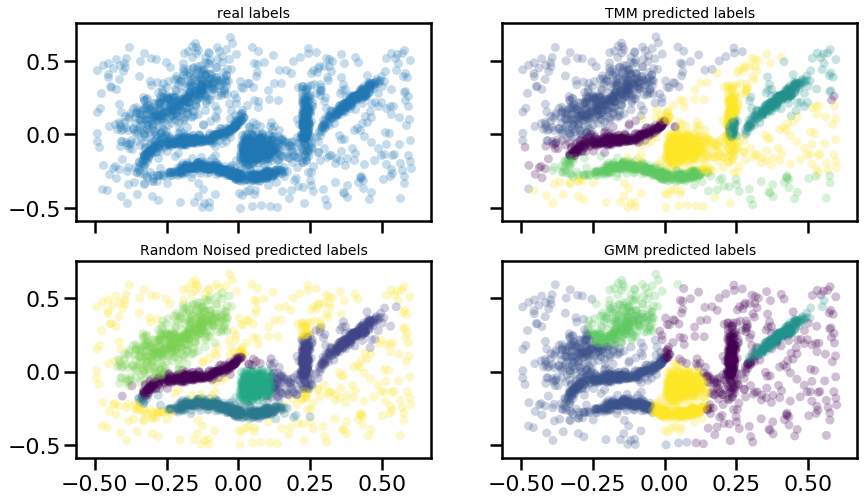

In [9]:
X = np.load('data/clusterable_data.npy')
model_noise = my_GMM_rnd_noise(k = 5)
model_noise.fit(X, it_max = 1000, tol = 10**-6)
model_tmm = my_tMM(k=5)
model_tmm.fit(X, it_max = 1000, tol = 10**-6, init ='random')
model_gmm = my_GMM(k = 5)
model_gmm.fit(X, it_max = 1000, tol = 10**-8);
labels = None

fig, ax = plt.subplots(2,2, figsize =(14, 8), sharex = True, sharey = True)
ax = ax.flatten()
ax[0].scatter(X[:, 0].T, X[:, 1].T, c=labels, **plot_kwds)
ax[0].set_title('real labels', size = 14)
ax[1].scatter(X[:, 0].T, X[:, 1].T, c=model_tmm.labels_, **plot_kwds)
ax[1].set_title('TMM predicted labels', size = 14);
ax[2].scatter(X[:, 0].T, X[:, 1].T, c=model_noise.labels_, **plot_kwds)
ax[2].set_title('Random Noised predicted labels', size = 14)
ax[3].scatter(X[:, 0].T, X[:, 1].T, c=model_gmm.labels_, **plot_kwds)
ax[3].set_title('GMM predicted labels', size = 14);

5 - Modify the my_GMM class to implement the trimmed EM for GMM

In [10]:
class my_GMM_trimmed():
    
    def __init__(self, k, alpha_trimmed):
        ### alpha_trimmed is the proportion of data 
        ## that will be kept at each iteration
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.alpha_trimmed = alpha_trimmed
        
    def fit(self, X, tol = 10**-6, it_max = 100):
        n, p = X.shape
        k = self.k
        self.mu_ = KMeans(n_clusters=k, max_iter=50).fit(X).cluster_centers_
        #self.mu_ = 1- 2 * np.random.rand(k, p)
        self.Sigma_ = np.zeros((k, p, p))
        for i in range(k) :
            self.Sigma_[i, :] = make_sparse_spd_matrix(p)
        self.alpha_ = np.random.rand(k)
        self.alpha_ = self.alpha_/np.sum(self.alpha_)
        
        self.cond_prob_ = np.zeros((n, k))
        it = 0
        convergence = False
        
        while not convergence :
            density = np.zeros((n, k))
            for i in range (k):
                density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
            
            cond_prob_ = self.alpha_.T * density
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_ 
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
            
            max_prob = np.amax(self.cond_prob_, axis = 1)
            ## we define a threshold as the (1 - alpha) percentile of the max conditional probabilities
            
            threshold = np.percentile(max_prob, 100. * (1. - self.alpha_trimmed))
            ind_to_keep = np.where(max_prob > threshold)[0]
            
            ### We update the parameters of the model by using the data that have the biggest probabilities
            ### of following a gaussian distribution
            
            X_trimmed = X[ind_to_keep]           

            mu_ = (1/self.alpha_)[:k, np.newaxis] * np.mean(np.expand_dims(X_trimmed, axis = 1) * self.cond_prob_[ind_to_keep, :k, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            tmp = np.expand_dims(X_trimmed, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = (1/self.alpha_)[:, np.newaxis, np.newaxis] * np.mean(self.cond_prob_[ind_to_keep, :k, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                              axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            it = it + 1
            err = delta_alpha + delta_cond_prob + delta_mu_ + delta_sigma
            if it > it_max or (err < tol) :
                convergence  = True
                
        print("Fin du fitting à l'iteration :", it , '. Error : ', err)   
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)   
        
        return self
        

6 - Compare the 4 methods in one example

In [11]:
X_1, labels_1 = generate_data(k = 4, p = 2, scale_dof=20, seed = 12)
X = X_1

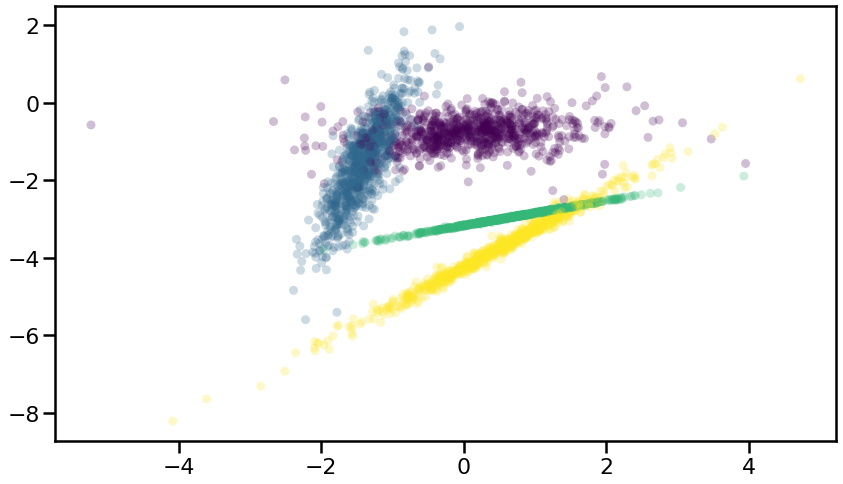

In [12]:
fig, ax = plt.subplots(1,1, figsize =(14, 8), sharex = True, sharey = True)
ax.scatter(X[:, 0].T, X[:, 1].T, c=labels_1, **plot_kwds)

In [13]:
model_gmm_tr = my_GMM_trimmed(k = 4,  alpha_trimmed = .98) ## alpha_trimmed is the proportion of data 
                                                          ## that is kept at each iteration
model_gmm_tr.fit(X, it_max = 10000, tol = 10**-8); 
model_gmm = my_GMM(k = 4)
model_gmm.fit(X, it_max = 1000, tol = 10**-8);
model_noise = my_GMM_rnd_noise(k = 4)
model_noise.fit(X, it_max = 1000, tol = 10**-8)
model_tmm.fit(X, it_max = 1000, tol = 10**-6, init = 'kmeans');

Fin du fitting à l'iteration : 10001 . Error :  0.5738806128276255
Fin du fitting à l'iteration : 35 . Error :  8.060907268070405e-09
Fin du fitting à l'iteration : 45 . Error :  8.396754555550778e-09
Fin du fitting à l'iteration : 134 . Error :  9.241689400696362e-07


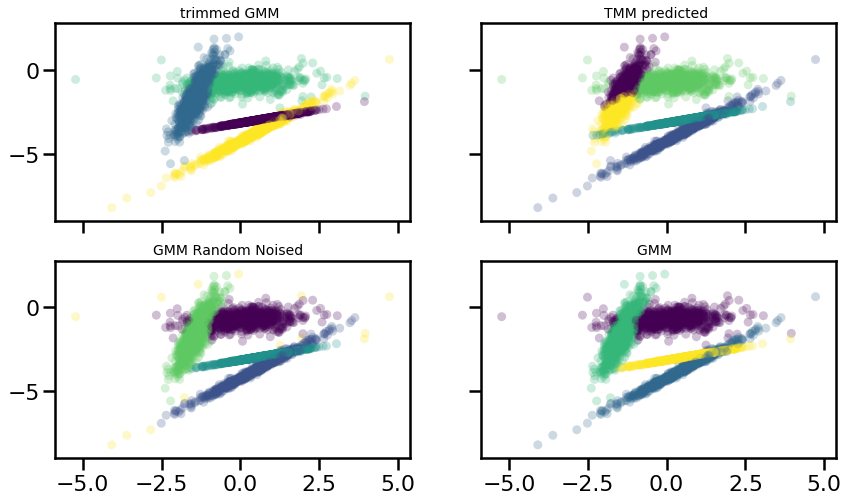

In [14]:
fig, ax = plt.subplots(2,2, figsize =(14, 8), sharex = True, sharey = True)
ax = ax.flatten()
ax[0].scatter(X[:, 0].T, X[:, 1].T, c=model_gmm_tr.labels_, **plot_kwds)
ax[0].set_title('trimmed GMM ', size = 14)
ax[1].scatter(X[:, 0].T, X[:, 1].T, c=model_tmm.labels_, **plot_kwds)
ax[1].set_title('TMM predicted ', size = 14);
ax[2].scatter(X[:, 0].T, X[:, 1].T, c=model_noise.labels_, **plot_kwds)
ax[2].set_title('GMM Random Noised  ', size = 14)
ax[3].scatter(X[:, 0].T, X[:, 1].T, c=model_gmm.labels_, **plot_kwds)
ax[3].set_title('GMM  ', size = 14);

Observation :
The trimmed EM we implemented doesn't always converge. Indeed it seems that in order to make the EM step to converge, the data with which the parameters are update musn't change a lot. Thus, the algorithm converge well with values of alpha_trimmed > .95 

**BONUS (not graded):** Implement the trimming EM clustering algorithm TCLUST (https://arxiv.org/pdf/0806.2976.pdf) 